# Beta-Variational Autoencoder Experiments

In [46]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from PIL import Image
import os

import numpy as np
import matplotlib.pyplot as plt

import glob
import os
import matplotlib

# FOR ANIMATION
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128
device='cuda'

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image

In [35]:
def imshow(imgs1, imgs2=None, ax=None):
    
    npimg1 = imgs1.detach().numpy()

    if imgs2 is not None:
            npimg2 = imgs2.detach().numpy()

            if np.any(ax) is None:
                fig, ax = plt.subplots(1, 2, figsize=(8, 4))
                
            ax[0].imshow(np.transpose(npimg1, (1, 2, 0)))
            ax[1].imshow(np.transpose(npimg2, (1, 2, 0)))
            ax[0].set_axis_off()
            ax[1].set_axis_off()
            plt.tight_layout()        
    
    else:
        if np.any(ax) is None:
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.imshow(np.transpose(npimg1, (1, 2, 0)))
        ax.set_axis_off()
        plt.tight_layout()

In [36]:
class VAE(nn.Module):
    def __init__(self, z_size = 32, in_channels=3):
        super().__init__()

        self.z_size = z_size

        # Architecture based on B-VAE paper by Higgins et al, (ICLR, 2017)
        # ------------------------
        self.encoder = nn.Sequential(*[
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),

            # flatten for linear layer
            nn.Flatten(1, -1),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=256, out_features=self.z_size * 2), # 32 mu, 32 var
        ])

        self.decoder = nn.Sequential(*[
            # Start with the linear layers
            nn.Linear(in_features=self.z_size, out_features=256),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=256, out_features=1024),
            nn.ReLU(inplace=True),
            
            # Reshape from flat vector to feature map
            nn.Unflatten(1, (64, 4, 4)),
            
            # Transposed convolutions
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, padding=1, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=in_channels, kernel_size=4, padding=1, stride=2),
            
        ])

        # apply weights       
        self.apply(self._init_weights)

    def z_sample(self, mu, var):

        # make sure sigma is (+)
        sigma = var ** 0.5

        # generate eps, reparam trick
        mean, std = (0, 1)
        eps = torch.normal(mean, std, size=(self.z_size,)).to(device) # just 1 sample needed since SGD is noisy anyway!

        # generate z var with reparam trick
        z = mu + sigma * eps

        return z

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        enc_out = self.encoder(x)
        mu = enc_out[:, :self.z_size]
        raw_var = enc_out[:, self.z_size:]
        var = torch.exp(raw_var).to(device)
        log_var = torch.log(var)

        z = self.z_sample(mu, var)
        y = self.decoder(z) # reconstruction
        
        return y, mu, log_var

In [37]:
# Define the ELBO loss function
def elbo_loss(recon_x, x, mu, log_var, Beta = 1):
    # negative likelihood = neg SUM ln(p(x|z,w)) --> decoder
    # basically becomes MSE for MLE of continuous regression with assumed Gaussian error
    # can be interpreted as "reconstruction loss"
    neg_log_likelihood = nn.functional.mse_loss(recon_x.view(-1), x.view(-1), reduction='sum')

    # KL(q||p) term in ELBO Lowerbound, q = posterior from encoder, p = Gaussian prior
    # log_var.exp() is basically var
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) * Beta

    # note this formulation is negative Lowerbound (ELBO), because we want to minimize this instead of maximize
    return neg_log_likelihood + kl_div

In [38]:
# var = 0.5
# logvar = np.log(var)
# mu = -10
# -0.5 * np.sum(1 + logvar - mu**2 - var)
# torch.from_numpy(np.array([logvar])).exp()

In [39]:
# Training loop

def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        # data = data[0] # mnist
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = elbo_loss(recon_batch, data, mu, log_var, Beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        scheduler.step()
        
        # if batch_idx % 100 == 0:
        #     print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}")

    # print(f"====> Epoch: {epoch} Average loss: {train_loss / len(dataloader.dataset):.4f}")

# Run the training

def train_model(num_epochs=50):
    for epoch in range(1, num_epochs + 1):
        train(epoch)

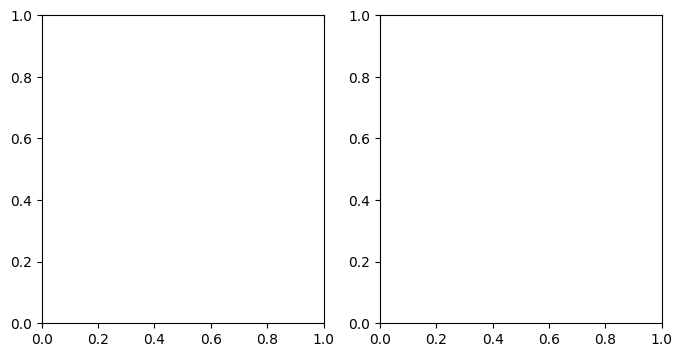

In [43]:
# animation
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

def animate(iter):
    global model 

    epochs = 1
    model = train_model(num_epochs=epochs)
    
    [ax.clear() for ax in axs]

    # VAE
    vae.eval()
    
    out = vae(test_imgs.to(device))[0]
    
    gt = torchvision.utils.make_grid(test_imgs[:64])
    recon = torchvision.utils.make_grid(out.to("cpu")[:64])    

    title = f"Latent Size: {z_size} | Beta Coeff: {Beta} | Training Epoch {epochs * iter}"
    imshow(gt, recon, axs);

    return None

In [41]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),    
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0., 0., 0.), (1, 1, 1)),  # mean and std
    # transforms.Normalize((0.), (1,)),  # mean and std
])

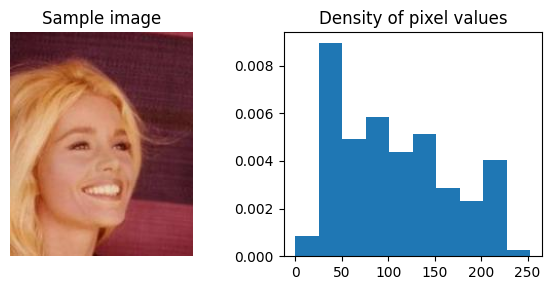

(218, 178, 3)


In [40]:
data_path = "../data/img_align_celeba/"
image_paths = glob.glob(os.path.join(data_path, "*.jpg"))
img = plt.imread(image_paths[0])

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(img)
ax[0].set_axis_off()
ax[0].set_title("Sample image")

ax[1].hist(img.flatten(), density=True)
ax[1].set_title("Density of pixel values")

plt.tight_layout()
plt.show()
print(img.shape)

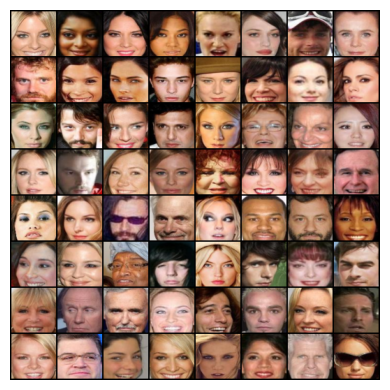

In [42]:
batch_size = 1024
num_workers = 20

# # Create the dataset
dataset = CustomImageDataset(image_paths=image_paths, transform=transform)

# dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# get some random training images
dataiter = iter(dataloader)
test_imgs = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(test_imgs[:64]))
# imshow(torchvision.utils.make_grid(test_imgs[:64])) #mnist

In [44]:
Beta = 1 # for ELBO
z_size = 6
in_channels = 3

vae = VAE(z_size=z_size, in_channels=in_channels).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1000)

vae(next(dataiter).to(device))[0].shape
# vae(test_imgs.to(device))[0].shape # mnist

torch.Size([1024, 3, 64, 64])

In [47]:
anim = animation.FuncAnimation(fig, 
                               animate, 
                               frames=3, 
                               interval=1)
HTML(anim.to_jshtml(fps=10))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_69061/3312718433.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

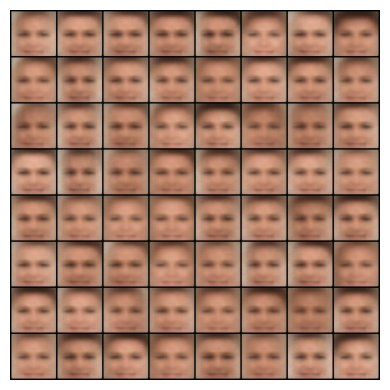

In [48]:
# generate some random z
vae.eval()
z = vae.z_sample(mu = torch.rand((64, vae.z_size)).to(device), var=torch.rand((64, vae.z_size)).to(device)).view(64, -1)
out = vae.decoder(z).to("cpu")
imshow(torchvision.utils.make_grid(out.to("cpu")[:64]))